In [11]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
import data_util  
from datetime import datetime
import copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler



In [12]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

from keras.callbacks import Callback

# Custom callback to display output every 'n' epochs
class VerboseEveryN(Callback):
    def __init__(self, n=5):
        super(VerboseEveryN, self).__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            print(f"Epoch {epoch+1} - {logs}")

In [13]:
def split_data(data,percent_split):
    size=(int((np.shape(data)[0])*(percent_split/100)))
    return data[0:size], data[size:]

	
# train_data,test_data=split_data(data, 70)

def create_dataset(data, step):
	X, Y = list(), list()

	for i in range(len(data)-step-1):
		X.append(data[i:(i+step), 0])
		Y.append(data[i + step, 0])
	return np.array(X), np.array(Y)

def make_model(step ,numOfStacks, num_neurons):
    model=Sequential()
    model.add(LSTM(num_neurons[0],return_sequences=True,input_shape=(step,1)))
    for i in range(1,numOfStacks-1):
        model.add(LSTM(num_neurons[i],return_sequences=True))
    model.add(LSTM(num_neurons[-1]))
    
    model.add(Dense(1))
    return model

In [14]:
def Lstm(stock_name,stock,epochs=10,step=100,numOfStacks=3,num_neurons=[64,64,50]):
    fit=MinMaxScaler(feature_range=(0,1))
    unscaled_data=np.array(list(stock['Close']))
    data=fit.fit_transform(np.array(list(stock['Close'])).reshape(-1,1))
    train_data,test_data=split_data(data, 70)
    # step = 100
    x_train, y_train = create_dataset(train_data, step)
    x_test, y_test = create_dataset(test_data, step)
    #1 is representing the number of features we are using , here we are doing univariate LSTM . Therefore , 1
    x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

    # numOfStacks=3
    # num_neurons=[64,64,50]
    model=make_model(step , numOfStacks,num_neurons)
    model.compile(loss='mean_squared_error',optimizer='adam')
    # model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=epochs,batch_size=64,verbose=2)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=64, verbose=0, callbacks=[VerboseEveryN(epochs/10)])
    train_predict=model.predict(x_train)
    test_predict=model.predict(x_test)    

    train_predict=fit.inverse_transform(train_predict)
    test_predict=fit.inverse_transform(test_predict)
    y_test=fit.inverse_transform(y_test.reshape(-1,1))
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(step*2)+1:len(data)-1] = test_predict
    # Plot the actual data in blue and the predicted data in red
    plt.plot(unscaled_data[:len(train_data)+len(unscaled_data)-len(test_predict)-len(train_data)], color='blue', label='Train Data Price')
    plt.plot(range(len(train_data)+len(unscaled_data)-len(test_predict)-len(train_data),len(unscaled_data)),unscaled_data[len(train_data)+len(unscaled_data)-len(test_predict)-len(train_data):], color='red', label='Test data Price')
    plt.plot(testPredictPlot, color='orange', label='Predicted Price')
    plt.legend()
    plt.show()
    model_path="UniLSTM"+stock_name+".h5"
    model.save(model_path)
    # print(test_predict.shape, y_test.shape)
    return test_predict,y_test
# need to add avaluation metrics here


[*********************100%%**********************]  1 of 1 completed
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - {'loss': 0.05767226964235306, 'val_loss': 0.022317320108413696}
Epoch 11 - {'loss': 0.0030304868705570698, 'val_loss': 0.0035981566179543734}
Epoch 21 - {'loss': 0.0019491472048684955, 'val_loss': 0.002970518544316292}
Epoch 31 - {'loss': 0.0016287502367049456, 'val_loss': 0.0017605706816539168}
Epoch 41 - {'loss': 0.0012823964934796095, 'val_loss': 0.001255309791304171}
Epoch 51 - {'loss': 0.0012164610670879483, 'val_loss': 0.005255917552858591}
Epoch 61 - {'loss': 0.0009315237402915955, 'val_loss': 0.002491575898602605}
Epoch 71 - {'loss': 0.0008358740014955401, 'val_loss': 0.0007225401932373643}
Epoch 81 - {'loss': 0.0007060789503157139, 'val_loss': 0.0005613380344584584}
Epoch 91 - {'loss': 0.0007720253779552877, 'val_loss': 0.0016612723702564836}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


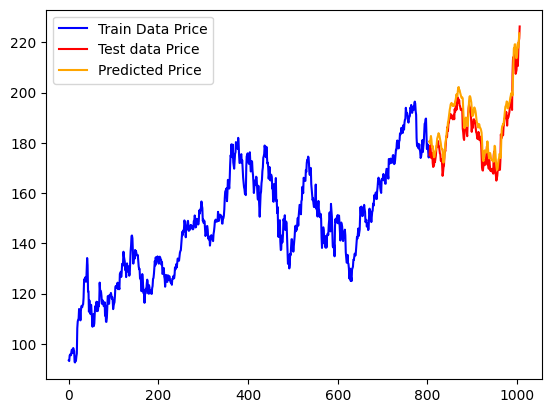

,Metric,Value
0,MAPE,2.32
1,MAE,4.24
2,MSE,23.60
3,RMSE,4.86
4,R2,0.84
5,SMAPE,2.28


In [15]:
a_stocks=data_util.stock_data('AAPL', 4,'Apple')
y_pred,y_true=Lstm("Apple",a_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - {'loss': 0.06516407430171967, 'val_loss': 0.02362782321870327}
Epoch 11 - {'loss': 0.002365577034652233, 'val_loss': 0.0025403841864317656}
Epoch 21 - {'loss': 0.00191193213686347, 'val_loss': 0.00333440862596035}
Epoch 31 - {'loss': 0.0017370954155921936, 'val_loss': 0.0022479312028735876}
Epoch 41 - {'loss': 0.0013468727702274919, 'val_loss': 0.0012132097035646439}
Epoch 51 - {'loss': 0.001186477835290134, 'val_loss': 0.0006602759240195155}
Epoch 61 - {'loss': 0.001085601863451302, 'val_loss': 0.0005439508240669966}
Epoch 71 - {'loss': 0.0012020948342978954, 'val_loss': 0.0020635079126805067}
Epoch 81 - {'loss': 0.0009130904800258577, 'val_loss': 0.0022259510587900877}
Epoch 91 - {'loss': 0.0008323646034114063, 'val_loss': 0.00039467334863729775}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


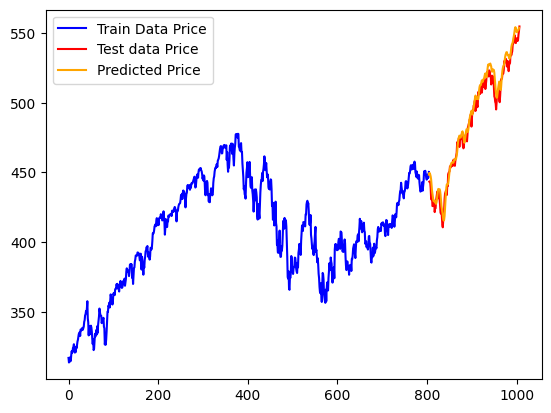

,Metric,Value
0,MAPE,0.97
1,MAE,4.68
2,MSE,33.94
3,RMSE,5.83
4,R2,0.98
5,SMAPE,0.96


In [16]:
s_stocks=data_util.stock_data('SPY', 4,'SPY')
y_pred,y_true=Lstm("SPY",s_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - {'loss': 0.05690493434667587, 'val_loss': 0.05165906250476837}
Epoch 11 - {'loss': 0.0011041526449844241, 'val_loss': 0.006966617424041033}
Epoch 21 - {'loss': 0.0009548867237754166, 'val_loss': 0.004952344577759504}
Epoch 31 - {'loss': 0.0009064737823791802, 'val_loss': 0.0034395356196910143}
Epoch 41 - {'loss': 0.0007720263092778623, 'val_loss': 0.0031967770773917437}
Epoch 51 - {'loss': 0.0007568604778498411, 'val_loss': 0.004430974368005991}
Epoch 61 - {'loss': 0.0006632285076193511, 'val_loss': 0.003031725762411952}
Epoch 71 - {'loss': 0.000563292414881289, 'val_loss': 0.0008103822474367917}
Epoch 81 - {'loss': 0.0007078121998347342, 'val_loss': 0.0038874209858477116}
Epoch 91 - {'loss': 0.00047583485138602555, 'val_loss': 0.0020686823409050703}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


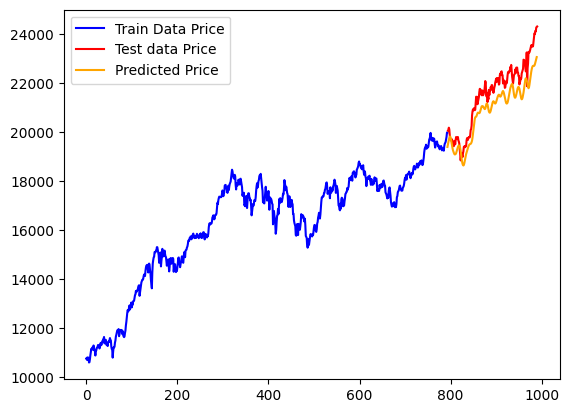

,Metric,Value
0,MAPE,3.04
1,MAE,665.66
2,MSE,548943.57
3,RMSE,740.91
4,R2,0.69
5,SMAPE,3.09


In [17]:
n_stocks=data_util.stock_data('^NSEI', 4,'Nifty 50')
y_pred,y_true=Lstm("^NSEI",n_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - {'loss': 0.12507592141628265, 'val_loss': 0.003924646880477667}
Epoch 11 - {'loss': 0.0033996766433119774, 'val_loss': 0.0016257746610790491}
Epoch 21 - {'loss': 0.0027193452697247267, 'val_loss': 0.0015824636211618781}
Epoch 31 - {'loss': 0.0023046296555548906, 'val_loss': 0.0010948216076940298}
Epoch 41 - {'loss': 0.0021628555841743946, 'val_loss': 0.0010122638195753098}
Epoch 51 - {'loss': 0.002070048823952675, 'val_loss': 0.001038011396303773}
Epoch 61 - {'loss': 0.0018450830830261111, 'val_loss': 0.0008239910821430385}
Epoch 71 - {'loss': 0.0015469263307750225, 'val_loss': 0.0007646073354408145}
Epoch 81 - {'loss': 0.0013207279844209552, 'val_loss': 0.0008825568365864456}
Epoch 91 - {'loss': 0.001204688916914165, 'val_loss': 0.0006218969938345253}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


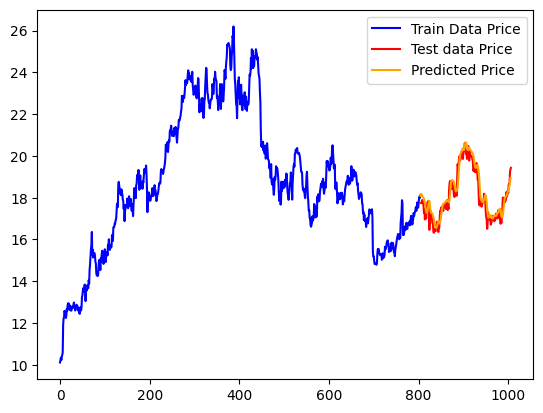

,Metric,Value
0,MAPE,1.72
1,MAE,0.31
2,MSE,0.16
3,RMSE,0.40
4,R2,0.88
5,SMAPE,1.70


In [18]:
i_stocks=data_util.stock_data('INFY', 4,'Infosys')
y_pred,y_true=Lstm("INFY",i_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df